In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

### Explore the dataset


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1455 entries, 2013-01-01 to 2016-12-31
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   transactions  1455 non-null   int64
dtypes: int64(1)
memory usage: 22.7 KB


<Axes: xlabel='date'>

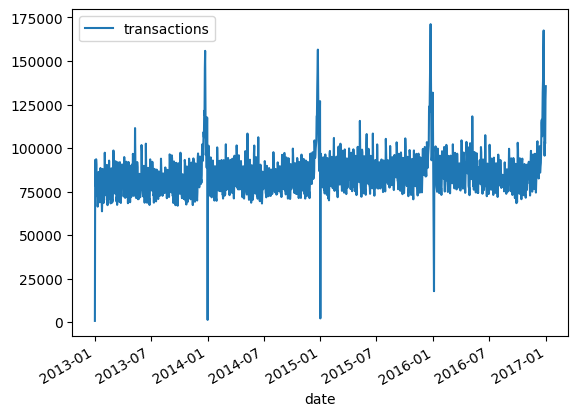

In [3]:
# Load the data files
df = pd.read_csv('train.csv')

df = df.set_index('date')
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')

df.info()
df.plot()

### Check for stationarity of time series

ACF (autocorrelation function) 

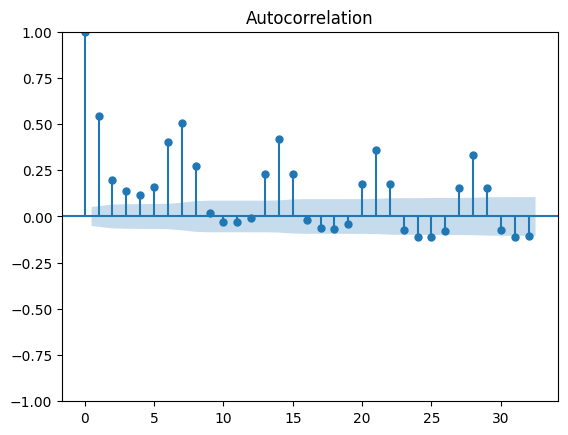

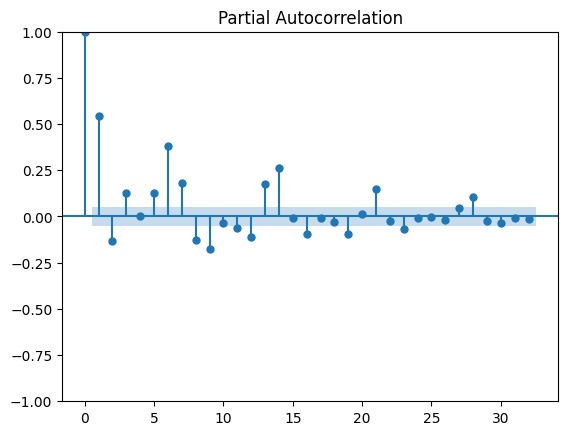

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_orginal = plot_acf(df)
pacf_original = plot_pacf(df)

In [5]:
# ADF test

from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df)
print(f'p-value: {adf_test[1]}')

p-value: 9.407649467775781e-05


### Split dataset to train and test

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2013-01-01 to 2015-12-31
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   transactions  1092 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2016-01-02 to 2016-12-31
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   transactions  363 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


<Axes: xlabel='date'>

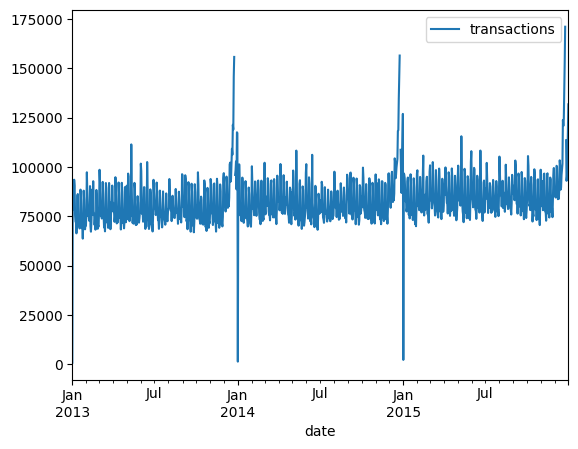

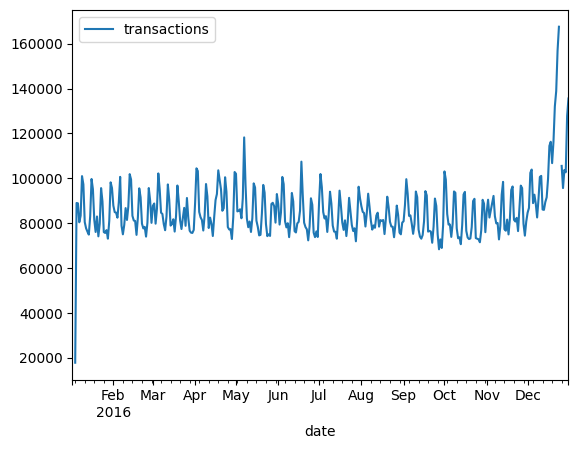

In [6]:
train = df.loc[df.index < '01-01-2016']
train.index = pd.to_datetime(train.index, format='%d-%m-%Y')
train = train.asfreq('D')

test = df.loc[df.index >= '01-01-2016']
test.index = pd.to_datetime(test.index, format='%d-%m-%Y')
test = test.asfreq('D')

train.info()
test.info()

train.plot()
test.plot()

### Check train and test datasets

In [7]:
has_nan = train.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

has_nan = train.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

train_interpolated_time = train.interpolate(method='time')
test_interpolated_time = test.interpolate(method='time')

has_nan = train_interpolated_time.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

has_nan = test_interpolated_time.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

Does the DataFrame have any NaN values?  True
Does the DataFrame have any NaN values?  True
Does the DataFrame have any NaN values?  False
Does the DataFrame have any NaN values?  False


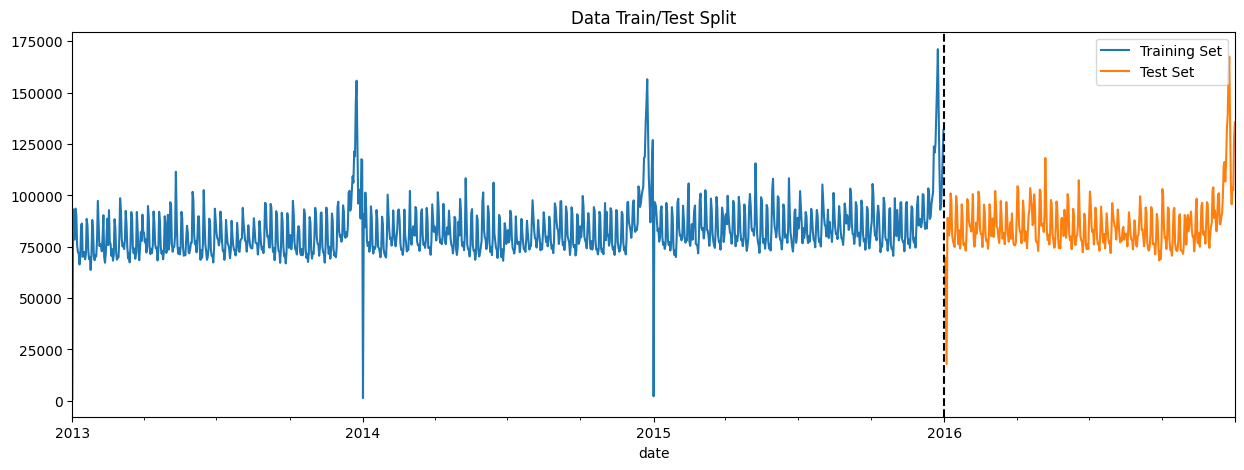

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
train_interpolated_time.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_interpolated_time.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Check how one week looks like

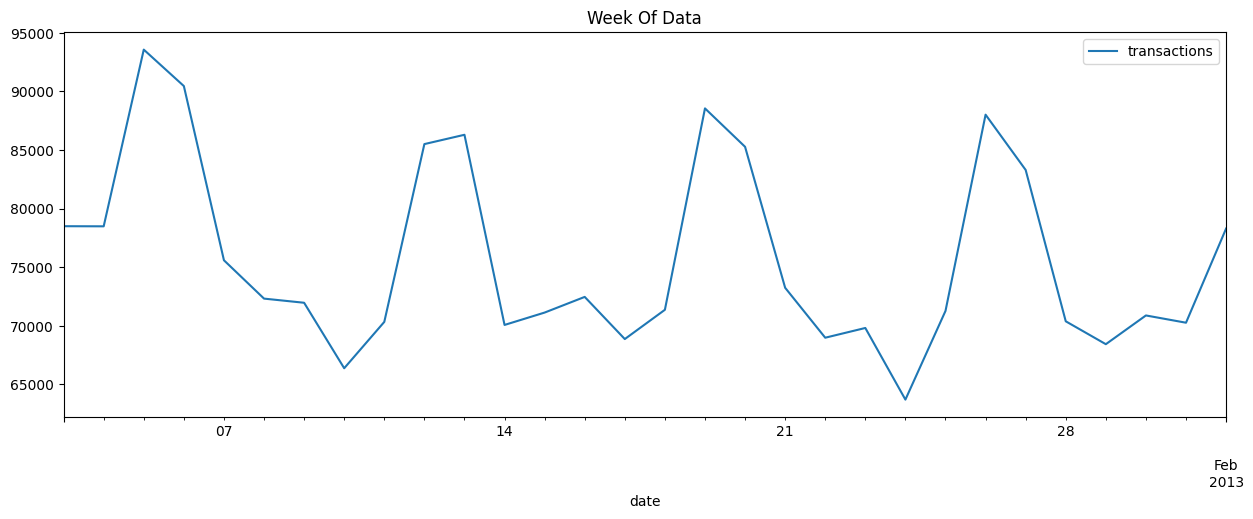

In [9]:
train_interpolated_time.loc[(train_interpolated_time.index > '01-02-2013') & (train_interpolated_time.index < '02-02-2013')].plot(figsize=(15, 5), title='Week Of Data')
plt.show()

### Create time series features based on time series index

            transactions  dayofweek  quarter  month  year  dayofyear  \
date                                                                   
2013-01-01           770          1        1      1  2013          1   
2013-01-02         93215          2        1      1  2013          2   
2013-01-03         78504          3        1      1  2013          3   
2013-01-04         78494          4        1      1  2013          4   
2013-01-05         93573          5        1      1  2013          5   
...                  ...        ...      ...    ...   ...        ...   
2016-12-27         95643          1        4     12  2016        362   
2016-12-28        103717          2        4     12  2016        363   
2016-12-29        102665          3        4     12  2016        364   
2016-12-30        127771          4        4     12  2016        365   
2016-12-31        135568          5        4     12  2016        366   

            dayofmonth  weekofyear  
date                      

C:\Users\ira\AppData\Local\Temp\ipykernel_30528\99779818.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_with_features, x='month', y='transactions', palette='Blues')


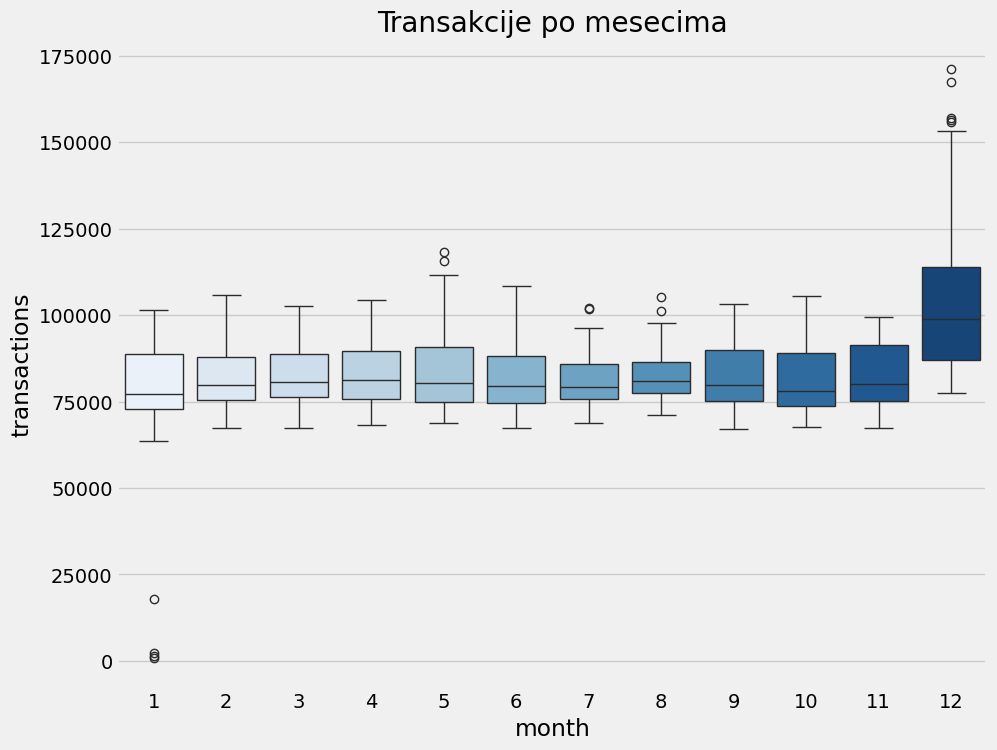

In [10]:
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')



def create_features(df):

    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_with_features = create_features(df)
print(df_with_features)

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_with_features, x='month', y='transactions', palette='Blues')
ax.set_title('Transakcije po mesecima')
plt.show()

### Format data for prophet model using ds and y & Model fit

In [11]:
from prophet import Prophet

train_with_features = create_features(train_interpolated_time)
test_with_features = create_features(test_interpolated_time)

train_prophet = train_with_features.reset_index().rename(columns={'date':'ds', 'transactions':'y'})
test_prophet = test_with_features.reset_index().rename(columns={'date':'ds', 'transactions':'y'})

model = Prophet()
model.fit(train_prophet)

Importing plotly failed. Interactive plots will not work.
15:55:00 - cmdstanpy - INFO - Chain [1] start processing
15:55:00 - cmdstanpy - INFO - Chain [1] done processing


### Forecasting

            ds           yhat
0   2016-01-02  115683.832581
1   2016-01-03  108701.407441
2   2016-01-04   96258.934335
3   2016-01-05   91528.611955
4   2016-01-06   90773.804898
..         ...            ...
360 2016-12-27  111733.750480
361 2016-12-28  111568.378830
362 2016-12-29  106637.511766
363 2016-12-30  109494.319297
364 2016-12-31  122802.728826

[365 rows x 2 columns]


c:\Users\ira\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ira\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


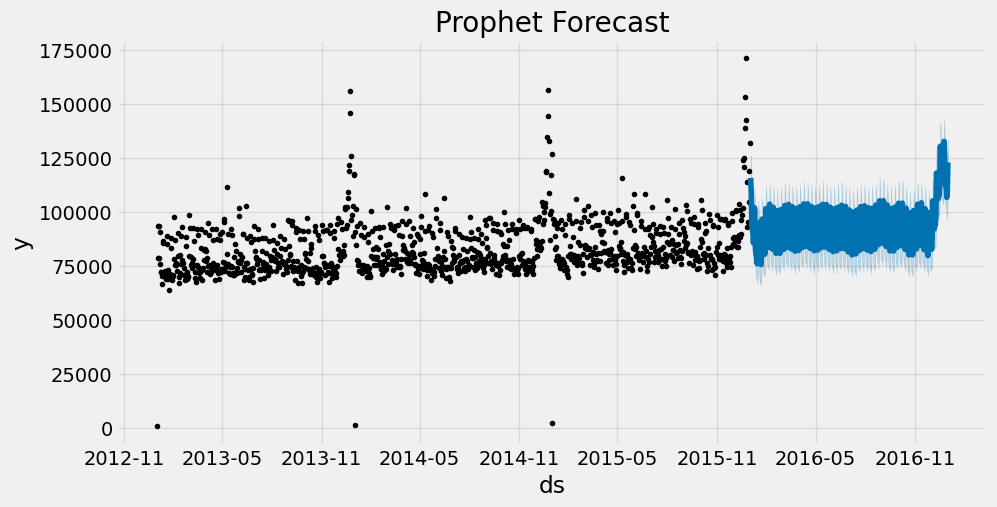

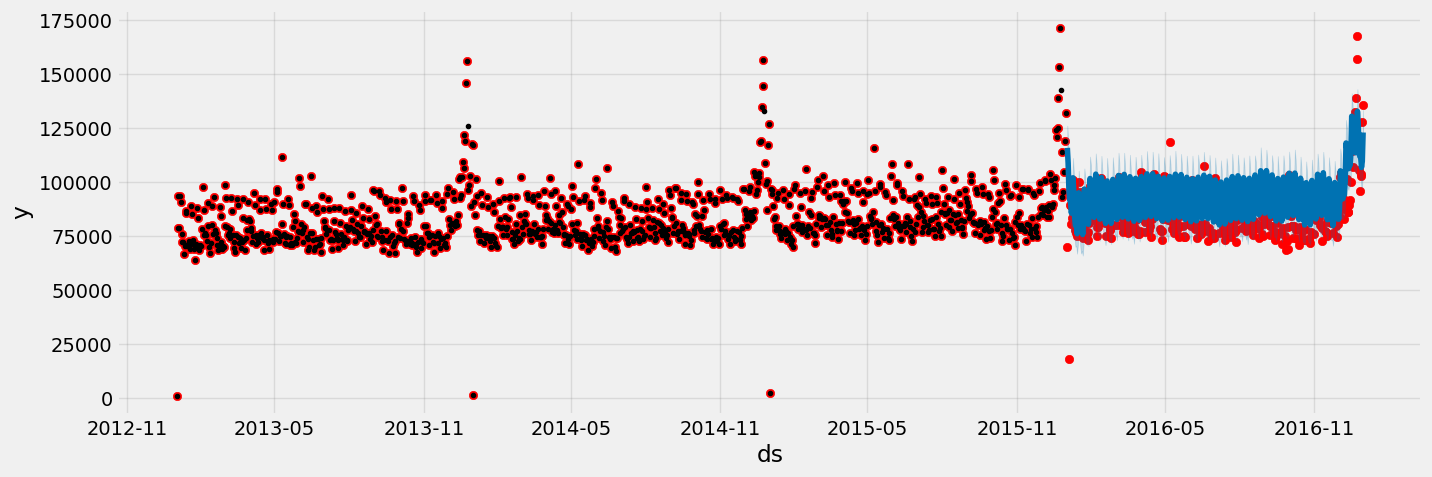

In [13]:
test_forecast = model.predict(test_prophet)
print(test_forecast[['ds', 'yhat']])

fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_forecast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df.index, df['transactions'], color='r')
fig = model.plot(test_forecast, ax=ax)

In [14]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

realData = test_with_features.loc[(test_with_features.index > '01-01-2016')]['transactions']
forecastData = test_forecast.loc[(test_forecast.ds > '01-01-2016')]

# print(forecastData['yhat'])

mae = mean_absolute_error(realData, forecastData['yhat']) # koliko su predikcije modela u proseku udaljene od stvarnih vrednosti
mape = mean_absolute_percentage_error(realData, forecastData['yhat']) # izražava grešku u procentima
rmse = np.sqrt (mean_squared_error(realData, forecastData['yhat'])) # prosečna kvadratna greška između predikovanih i stvarnih vrednosti
print (f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 7262.048456421981
mape - manual: 0.09722477805981192
rmse - manual: 10195.466646189743
